# Select representative decomposition results

It is well known that matrix decomposition algorithms that aims to miminize the cost function can have non-unique solutions. Here we look into the results of 320 tsNMF runs with different initial conditions and select ones for plotting in the paper.

In [1]:
import os
import glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import dill

## Load low-rank MVBS data

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [4]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [5]:
low_rank_nonneg = low_rank - low_rank.min()
low_rank_nonneg.shape

(62, 15984)

## Get pre-calculated tsNMF results filenames

In [6]:
# Rank=1 results
r1_path = '../data/precalc_tsnmf/smoothness_sweep_dict/sm5e5_sp0_rank1only/'
r1_fname = sorted(glob.glob(os.path.join(r1_path, '*.pkl')))

In [7]:
# Rank=2-8 results
other_path = '../data/precalc_tsnmf/smoothness_sweep_dict/sm5e5_sp0/'
other_fname = sorted(glob.glob(os.path.join(other_path, '*.pkl')))

In [8]:
# Combine all fnames
all_fname = r1_fname + other_fname

In [9]:
# Set all rank
rank_all = np.arange(1,10)

## MSE and smoothness regularization cost (SMC)

### Functions to calculate mse and smoothness cost

In [10]:
def calc_mse(output_holder, fname_list, data):
    """
    Calculate MSE for each model.

    Parameters
    ----------
    output_holder
        list to hold all MSE
    fname_list
        list of filename containing tsNMF results
    data
        data before decomposition
        `data = low_rank_nonneg.T` for the original data.    
        `data = data_shuffle_axday` for the shuffled data.
    """
    for ff in fname_list:
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)
        mse = []
        for mm in x:
            mse.append(np.linalg.norm(data - mm['W']@mm['H'])**2/low_rank_nonneg.size)
        output_holder += mse
    return output_holder

In [11]:
def calc_smc(output_holder, fname_list):
    """
    Calculate sparsity reg cost from each model.
    
    Parameters
    ----------
    output_holder
        list to hold all MSE
    fname_list
        list of filename containing tsNMF results
    """
    for ff in fname_list:
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)
        smc = []
        for mm in x:
            smc.append(np.linalg.norm(mm['H'][:,1:] - mm['H'][:,:-1])**2)
        output_holder += smc
    return output_holder

### Compute MSE and SMC

In [12]:
mse_ori = calc_mse([], all_fname, data=low_rank_nonneg.T)
smc_ori = calc_smc([], all_fname)

In [13]:
# Sanity check: dimension should all be 320*9
len(mse_ori), len(smc_ori)

(2880, 2880)

Reshape these results for the next step:

In [14]:
mse_ori = np.array(mse_ori).reshape((len(rank_all),-1))
smc_ori = np.array(smc_ori).reshape((len(rank_all),-1))

In [15]:
# Sanity check: should be 9x320 = number of rank x number of runs per rank
mse_ori.shape

(9, 320)

### Distribution of MSE and SMC

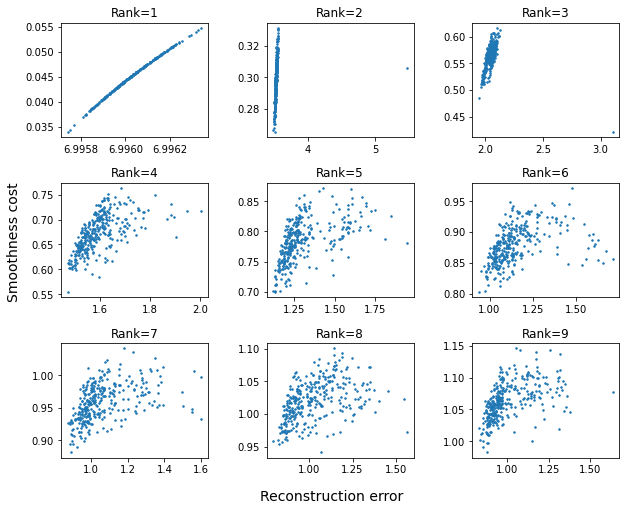

In [16]:
fig, ax = plt.subplots(3,3,figsize=(10,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for seq,rr in enumerate(rank_all):
    samples = np.vstack((mse_ori[seq,:], smc_ori[seq,:])).T
    axseq = np.unravel_index(seq,(3,3))
    ax[axseq].plot(samples[:,0], samples[:,1], '.', markersize=3)
    ax[axseq].set_title('Rank=%d'%rr)
fig.text(0.5, 0.05, 'Reconstruction error', fontsize=14, ha='center')
fig.text(0.05, 0.5, 'Smoothness cost', fontsize=14, va='center', rotation='vertical')
plt.show()

We can see that for rank=2 and rank=3, there is each one significant outlier with large MSE, whereas for all other ranks the spread is not as large.

### k-means clustering to separate outliers

In [17]:
from sklearn.cluster import KMeans

First shot: what if we try to separate the runs into 2 clusters for all rank >=2?

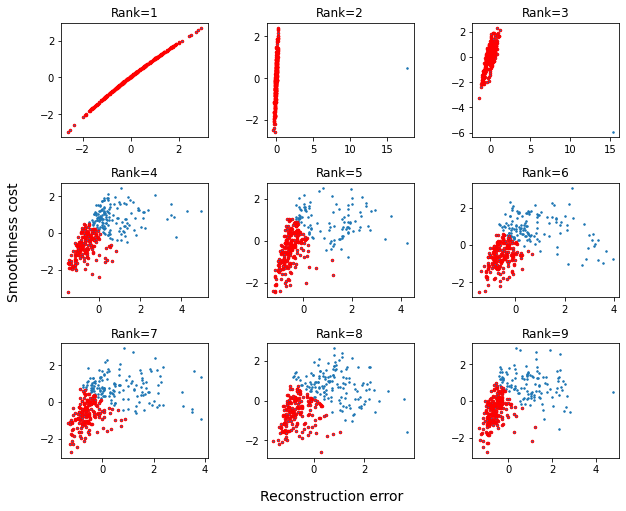

In [18]:
runs_wanted = []
fig, ax = plt.subplots(3,3,figsize=(10,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for seq,rr in enumerate(rank_all):
    samples = np.vstack((mse_ori[seq,:], smc_ori[seq,:])).T
    samples = (samples - samples.mean(axis=0)) / samples.std(axis=0)  # standardize
    if rr>1:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
    else:
        kmeans = KMeans(n_clusters=1, random_state=0).fit(samples)
    which_is_good = kmeans.cluster_centers_[:,0].argmin(axis=0)
    runs_wanted.append(kmeans.labels_==which_is_good)
    axseq = np.unravel_index(seq,(3,3))
    ax[axseq].plot(samples[:,0], samples[:,1], '.', markersize=3)
    ax[axseq].plot(samples[kmeans.labels_==which_is_good, 0], 
                   samples[kmeans.labels_==which_is_good, 1], 
                   'r.', markerfacecolor='none', markersize=5)
    ax[axseq].set_title('Rank=%d'%rr)
fig.text(0.5, 0.05, 'Reconstruction error', fontsize=14, ha='center')
fig.text(0.05, 0.5, 'Smoothness cost', fontsize=14, va='center', rotation='vertical')
plt.show()

We can see that for rank>=4, the clustering creates an artificial boundary that doesn't really make sense.

It is more reasonable if we only remove the single outliers for rank=2 and rank=3.

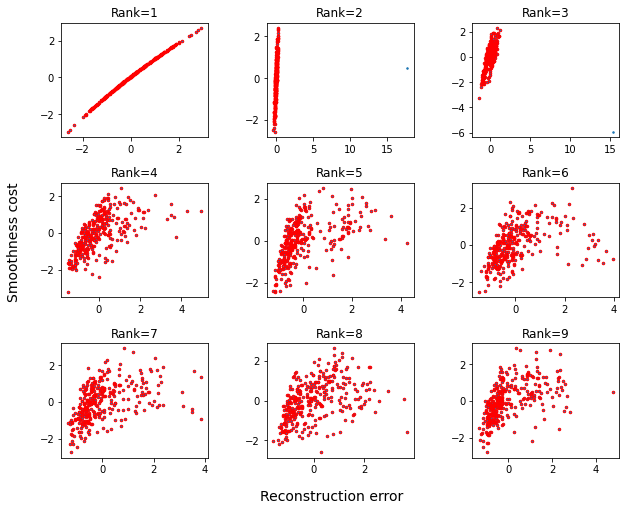

In [19]:
runs_wanted = []
fig, ax = plt.subplots(3,3,figsize=(10,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for seq,rr in enumerate(rank_all):
    samples = np.vstack((mse_ori[seq,:], smc_ori[seq,:])).T
    samples = (samples - samples.mean(axis=0)) / samples.std(axis=0)  # standardize
    if rr==2 or rr==3:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
    else:
        kmeans = KMeans(n_clusters=1, random_state=0).fit(samples)
    which_is_good = kmeans.cluster_centers_[:,0].argmin(axis=0)
    runs_wanted.append(kmeans.labels_==which_is_good)
    axseq = np.unravel_index(seq,(3,3))
    ax[axseq].plot(samples[:,0], samples[:,1], '.', markersize=3)
    ax[axseq].plot(samples[kmeans.labels_==which_is_good, 0], 
                   samples[kmeans.labels_==which_is_good, 1], 
                   'r.', markerfacecolor='none', markersize=5)
    ax[axseq].set_title('Rank=%d'%rr)
fig.text(0.5, 0.05, 'Reconstruction error', fontsize=14, ha='center')
fig.text(0.05, 0.5, 'Smoothness cost', fontsize=14, va='center', rotation='vertical')
plt.show()

### Reshape to according entries in the pre-calculated tsNMF results files

In [20]:
num_files_per_rank = 8
num_runs_per_file = 40

In [21]:
[np.nonzero(x)[0].shape[0] for x in runs_wanted]

[320, 319, 319, 320, 320, 320, 320, 320, 320]

In [22]:
def reshape_runs_to_per_file(runs_all):
    runs_each_file = np.array(runs_all).reshape(-1).reshape(-1,num_runs_per_file)
    runs_each_file = [np.nonzero(runs_each_file[x,:])[0] for x in range(runs_each_file.shape[0])]
    return runs_each_file

In [23]:
runs_wanted_per_file = reshape_runs_to_per_file(runs_wanted)

In [24]:
# Sanity check: should have 72 files in total
len(runs_wanted_per_file)

72

## Gather info from selected tsNMF runs

In [25]:
def gather_H_and_W(runs_wanted_per_file, container, fname, verbose=False):
    """
    Get H and W from the selected runs and put it into the container dictionary.
    """
    
    for seq_file,ff in enumerate(fname):
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)

        # Start fresh H and W lists for new rank
        #  e.g., each rank has 8 files, so seq_f%8=0 means the beginning of a rank
        if seq_file % num_files_per_rank == 0:  
            H, W, fn_ln = [], [], []
            if verbose:
                print('file %0d: '%seq_file +'starting new rank')

        # Collect H from good runs in file ff
        if verbose:
            print('gather H and W in file: %s' % os.path.basename(ff))
        for seq_line,mm in enumerate(x):  # loop through all results in this file
            if seq_line in runs_wanted_per_file[seq_file]:
                H.append(mm['H'])
                W.append(mm['W'])
                fn_ln.append([seq_file, seq_line])
        if verbose:
            print('   total %d Hs and Ws gathered' % len(H))

        # Save H and W lists for this rank to master dict
        if (seq_file+1) % num_files_per_rank == 0:
            container['H'].append(H)
            container['W'].append(W)
            container['filenum_linenum'].append(fn_ln)
            if verbose:
                print('file %0d: '%seq_file +'ending this rank')
                print('---------------------------------------')

In [26]:
# Get MSE and SMC from the good runs
tsNMF_results = defaultdict(list)

for rr in range(len(rank_all)):
    tsNMF_results['MSE'].append(mse_ori[rr, runs_wanted[rr]])
    tsNMF_results['SMC'].append(smc_ori[rr, runs_wanted[rr]])

In [27]:
# Gather H and W from the good runs
gather_H_and_W(runs_wanted_per_file, tsNMF_results, all_fname, verbose=True)

file 0: starting new rank
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch01.pkl
   total 40 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch02.pkl
   total 80 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch03.pkl
   total 120 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch04.pkl
   total 160 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch05.pkl
   total 200 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch06.pkl
   total 240 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch07.pkl
   total 280 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch08.pkl
   total 320 Hs and Ws gathered
file 7: ending this rank
---------------------------------------
file 8: starting new rank
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch01.pkl
   total 40 Hs and Ws gathered
gather H and W in file: ssNMF_sm5e+05_sp0.0_batch02.pkl
   total 80 Hs and Ws gathered
gather 

In [28]:
# Sanity check: should have 9 elements in this key
len(tsNMF_results['H'])

9

### Keep track of the original line number in the parameter file

`tsNMF_results['filenum_linenum']` contains the filenum and linenum matching information to figure out the random seed used for a specific run. Let's calculate that below.

In [29]:
# Sanity check that the number of entries in filenum_linenum is the same as MSE
len(tsNMF_results['filenum_linenum'][2]) == len(tsNMF_results['MSE'][2])

True

In [30]:
# Find original line number in param file
num_files_per_rank = 8
num_lines_per_file = 40

for seq, fn_ln in enumerate(tsNMF_results['filenum_linenum']):  # loop through all rank
    fn_ln = np.array(fn_ln)  # convert to np.array
    ln = (fn_ln[:,0] - seq*num_files_per_rank)*num_lines_per_file + fn_ln[:,1]
    tsNMF_results['filenum_linenum_original'].append(ln)

### Normalize H and W

In [31]:
for H_rank,W_rank in zip(tsNMF_results['H'], tsNMF_results['W']):
    H_multW, W_divW = [], []
    for H,W in zip(H_rank, W_rank):
        H_multW.append((H.T*np.linalg.norm(W, axis=0)).T)
        W_divW.append(W/np.linalg.norm(W, axis=0))
    tsNMF_results['H_multW'].append(H_multW)
    tsNMF_results['W_divW'].append(W_divW)

## Match tsNMF component sequence

The sequence of components for tsNMF (and NMF) are not ordered like in PCA. However to make it easier for us to compare results across runs and across rank, let's re-order them according to the sequence from NMF with NNDSVD initialization. 

### NMF with `nndsvd` initialization

This will take a bit of time to run.

In [32]:
from sklearn.decomposition import NMF

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
# NMF with NNDSVD initialization
NMF_NNDSVD = defaultdict(list)
for rr in rank_all:
    print('Rank = %d' % rr)
    # original
    NMF_tmp = NMF(n_components=rr, init='nndsvd' , max_iter=2000)
    H_tmp = NMF_tmp.fit_transform(low_rank_nonneg)
    W_tmp = NMF_tmp.components_
    NMF_NNDSVD['model'].append(NMF_tmp)
    NMF_NNDSVD['H'].append(H_tmp)
    NMF_NNDSVD['W'].append(W_tmp)

Rank = 1
Rank = 2
Rank = 3
Rank = 4
Rank = 5
Rank = 6
Rank = 7
Rank = 8
Rank = 9


### Component matching functions

In [35]:
def match_factors_by_W(Ws, NMF_Ws=None):
    """Ordering the components based on W components.
    """
    sample_num, _, rank_num = Ws.shape
    new_idx = np.zeros((sample_num, rank_num))
    if NMF_Ws is not None:
        Ws_ref = NMF_Ws.T
    else:
        Ws_ref = Ws[0,:,:]
    for k in range(sample_num):  # loop through all runs
        rho = np.corrcoef(Ws_ref.T, Ws[k,:,:].T)[:rank_num,rank_num:]
        index = [0 for r in range(rank_num)]
        for p in range(rank_num):
            index_max = np.argmax(rho)
            # index = np.argsort(rho, axis=1)
            i,j = np.unravel_index(index_max,(rank_num,rank_num))
            rho[:,j] = -2
            rho[i,:] = -2
            index[i] = j
        new_idx[k,:] = index
    return new_idx.astype(int)

In [36]:
def match_factors_by_H(Hs, NMF_Hs=None):
    """Ordering the components based on H curves.
    """
    sample_num, rank_num, _ = Hs.shape
    new_idx = np.zeros((sample_num, rank_num))
    if NMF_Hs is not None:
        Hs_ref = NMF_Hs
    else:
        Hs_ref = Hs[0,:,:].T
    for k in range(sample_num):  # loop through all runs
        rho = np.corrcoef(Hs_ref.T, Hs[k,:,:])[:rank_num,rank_num:]
        index = [0 for r in range(rank_num)]
        for p in range(rank_num):
            index_max = np.argmax(rho)
            # index = np.argsort(rho, axis=1)
            i,j = np.unravel_index(index_max,(rank_num,rank_num))
            rho[:,j] = -2
            rho[i,:] = -2
            index[i] = j
        new_idx[k,:] = index
    return new_idx.astype(int)

### Matching components based on classic NMF

In [37]:
match_idx_by_H_NMF = []
for r_idx in range(len(rank_all)):
    match_idx_by_H_NMF.append(match_factors_by_H(np.array(tsNMF_results['H'][r_idx]), 
                                                 NMF_Hs=NMF_NNDSVD['H'][r_idx]))

Rank=2 ========================== 


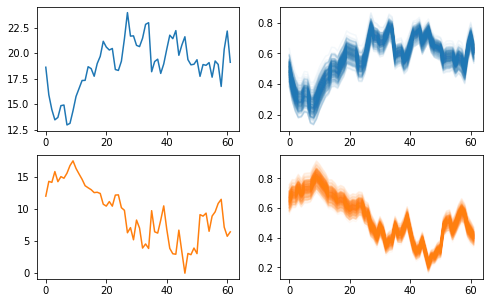

Rank=3 ========================== 


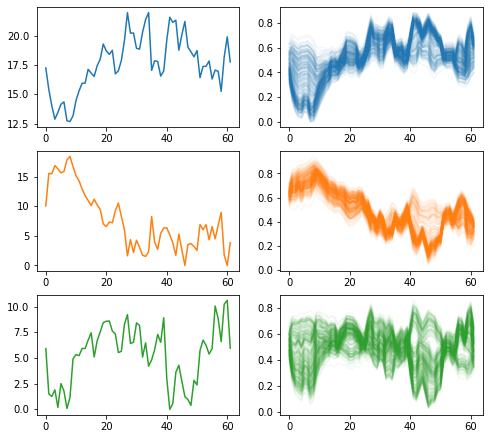

Rank=4 ========================== 


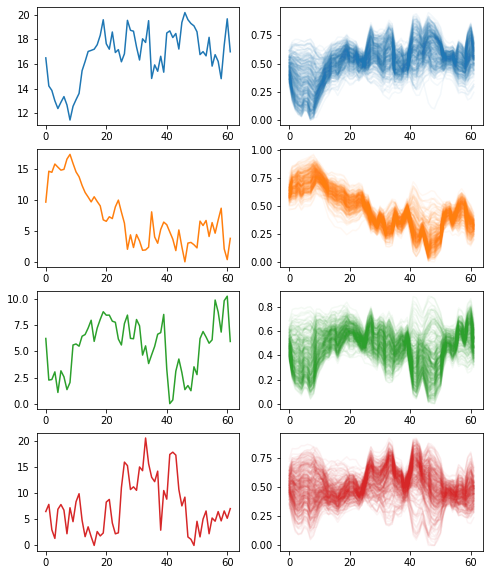

Rank=5 ========================== 


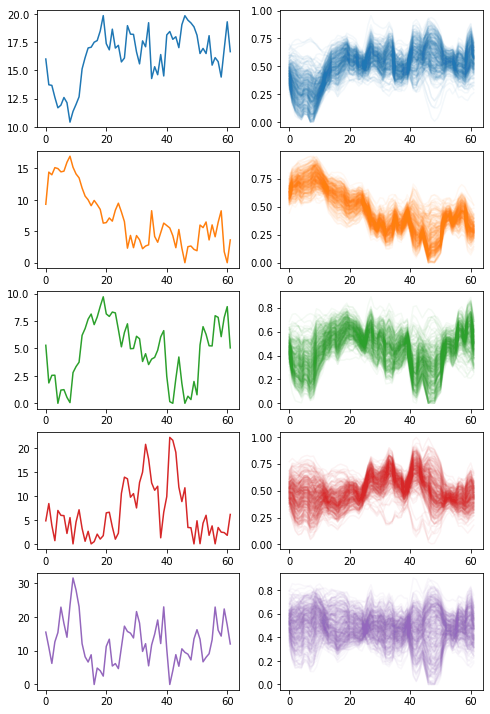

Rank=6 ========================== 


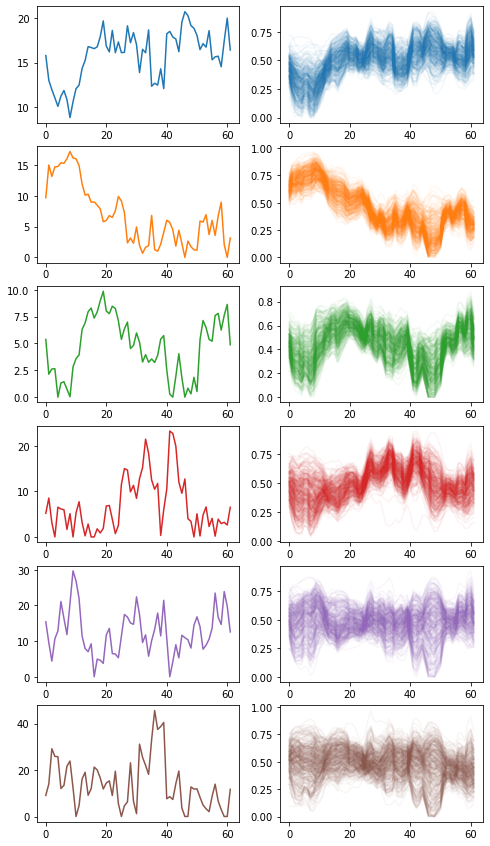

Rank=7 ========================== 


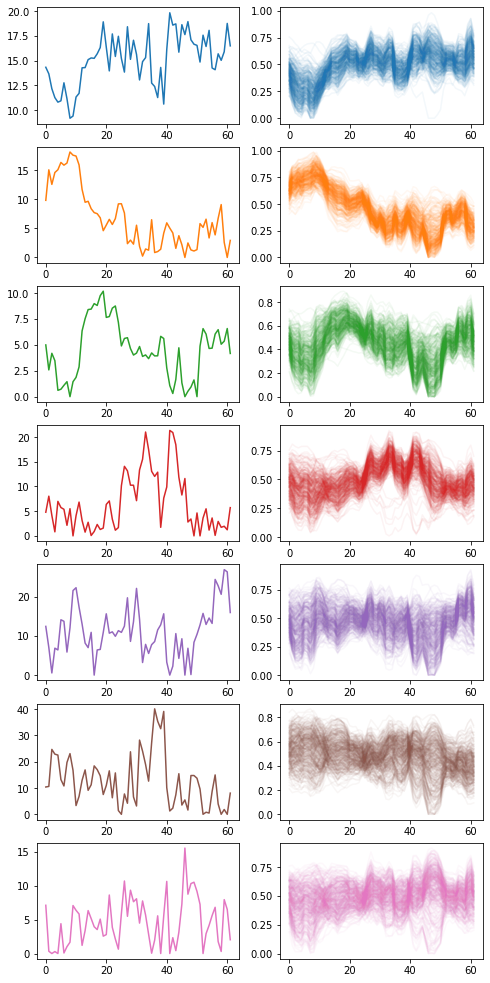

Rank=8 ========================== 


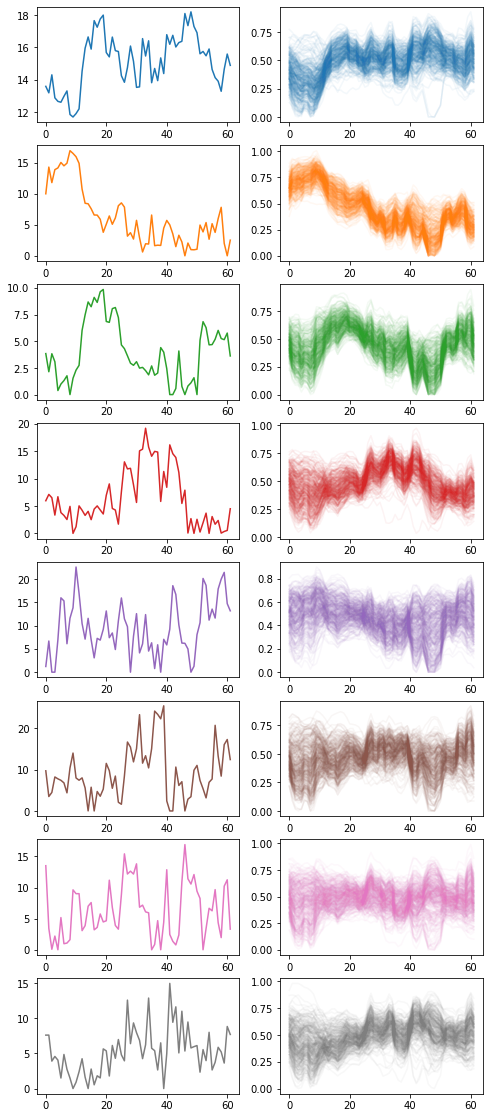

Rank=9 ========================== 


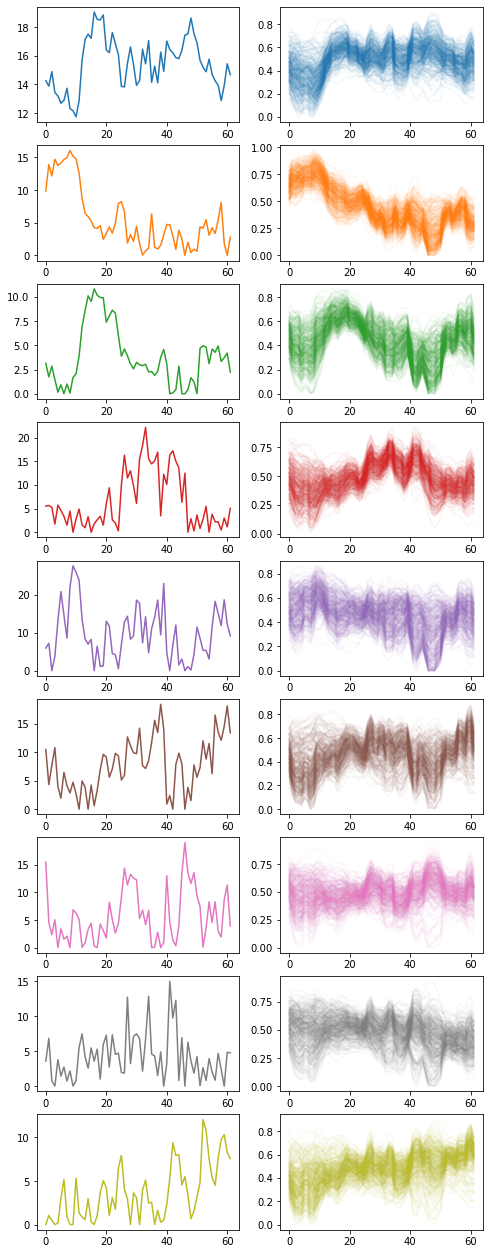

In [38]:
for rr in rank_all[1:]:  # not re-ordering involved for rank=1
    print('Rank=%d ========================== '%rr)
    r_idx = np.nonzero(rr==rank_all)[0][0]    # get index of this rank
    
    fig,ax = plt.subplots(rr, 2, figsize=(8,2.5*rr))
    for seq in range(rr):
        Hs = np.array(tsNMF_results['H'][r_idx])  # tsNMF results
        new_idx = match_idx_by_H_NMF[r_idx]       # new order
        ax[seq,0].plot(NMF_NNDSVD['H'][r_idx][:,seq], 'C%d'%seq)  # NMF results
        [ax[seq,1].plot(Hs[x,new_idx[x,seq],:], 'C%d'%seq, alpha=0.05) 
         for x in range(new_idx.shape[0])]
    plt.show()

## Select rank=3 run

In [39]:
rank_to_check = 3
r_idx = np.nonzero(rank_to_check==rank_all)[0][0]
run_idx_sorted = np.argsort(tsNMF_results['MSE'][r_idx])

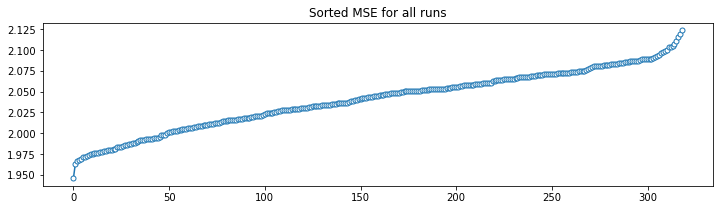

In [40]:
# Sanity check to make sure the MSE is sorted
plt.figure(figsize=(12,3))
plt.plot(tsNMF_results['MSE'][r_idx][run_idx_sorted], '.-', markersize=10, markerfacecolor='w')
plt.title('Sorted MSE for all runs')
plt.show()

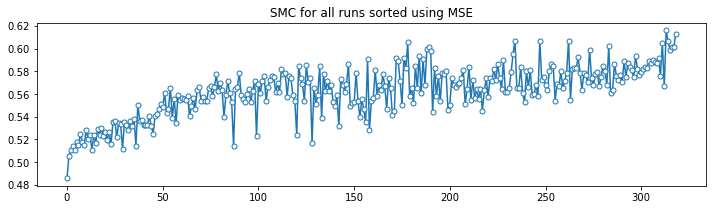

In [41]:
# Check SMC
plt.figure(figsize=(12,3))
plt.plot(tsNMF_results['SMC'][r_idx][run_idx_sorted], '.-', markersize=10, markerfacecolor='w')
plt.title('SMC for all runs sorted using MSE')
plt.show()

We know the lowest cost run for rank=3 is actually an outlier significantly below the majority of runs, so here we select the lowest of the main cluster.

In [42]:
# Select run_idx_sorted[1] instead of run_idx_sorted[0]
run_idx_sel = run_idx_sorted[1]

In [43]:
# component number sequence matching index
new_comp_seq_idx = match_idx_by_H_NMF[r_idx][run_idx_sel, :]  # instead of run_idx_sorted[0]

In [44]:
new_comp_seq_idx

array([0, 2, 1])

In [45]:
# sort and reshape Hs and Ws for display
H_type = 'H_multW'
W_type = 'W_divW'
Ws_reshaped = np.array(tsNMF_results[W_type][r_idx])[run_idx_sel, :, new_comp_seq_idx].\
                reshape(rank_to_check, n_frequencies*n_depth_levels, n_pings)
Hs_reshaped = np.array(tsNMF_results[H_type][r_idx])[run_idx_sel, new_comp_seq_idx, :].T

### Which random seed?

In [46]:
run_idx_sel

119

In [47]:
# run index selected
tsNMF_results['filenum_linenum_original'][r_idx][run_idx_sel]

119

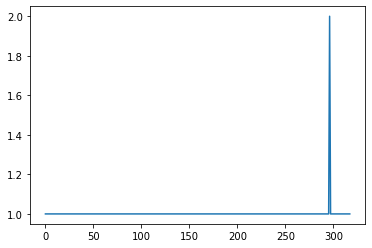

In [48]:
# check that we only exclude 1 run
plt.plot(np.diff(tsNMF_results['filenum_linenum_original'][r_idx]))  
plt.show()

In [49]:
# Double check we can recover that exact run
file_num_sel, line_num_sel = tsNMF_results['filenum_linenum'][r_idx][run_idx_sel]

In [50]:
all_fname[file_num_sel]

'../data/precalc_tsnmf/smoothness_sweep_dict/sm5e5_sp0/ssNMF_sm5e+05_sp0.0_batch11.pkl'

In [51]:
with open(all_fname[file_num_sel],'rb') as openfile:
    x = dill.load(openfile)

In [52]:
W_recover = x[line_num_sel]['W']
H_recover = x[line_num_sel]['H']

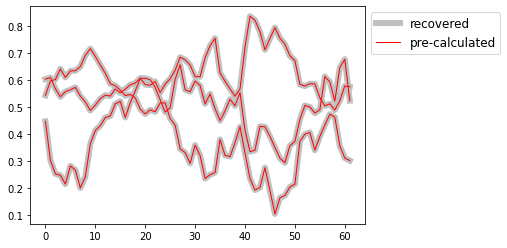

In [53]:
h1 = plt.plot(H_recover.T, color='silver', lw=6)
h2 = plt.plot(tsNMF_results['H'][r_idx][run_idx_sel].T, color='r', lw=1)
plt.legend([h1[0], h2[0]], ['recovered', 'pre-calculated'], fontsize=12, bbox_to_anchor=(1,1))
plt.show()

From the above we know that we can exactly recover this run.

### Sanity check: re-run tsNMF using the random seed

Let's see if we can re-run tsNMF can get the same output when using the same initial condition and early-stopping parameters.

In [54]:
import tsnmf

In [55]:
model = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=500000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model.fit(low_rank_nonneg.T, init='random', random_state=1190)

Stopping at iteration 702


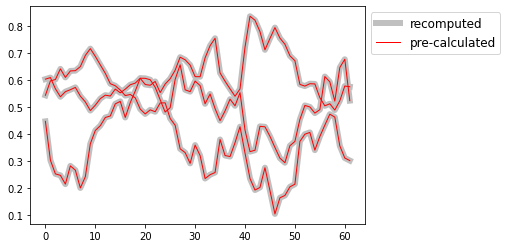

In [56]:
h1 = plt.plot(model.H.T, color='silver', lw=6)
h2 = plt.plot(tsNMF_results['H'][r_idx][run_idx_sel].T, color='r', lw=1)
plt.legend([h1[0], h2[0]], ['recomputed', 'pre-calculated'], fontsize=12, bbox_to_anchor=(1,1))
plt.show()

We have verified that this initial random seed does lead to exactly the same results.

## Select rank=4 run

Now we follow the same procedure above and select a run for rank=4.

In [57]:
rank_to_check = 4
r_idx = np.nonzero(rank_to_check==rank_all)[0][0]
run_idx_sorted = np.argsort(tsNMF_results['MSE'][r_idx])

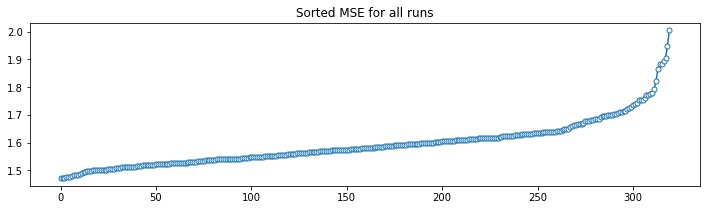

In [58]:
# Sanity check to make sure the MSE is sorted
plt.figure(figsize=(12,3))
plt.plot(tsNMF_results['MSE'][r_idx][run_idx_sorted], '.-', markersize=10, markerfacecolor='w')
plt.title('Sorted MSE for all runs')
plt.show()

From the MSE vs SMC figure above, we know that the run with the lowest MSE has an SMC that is significantly lower than the majority of runs. So again here we select the run with the lowest MSE and SMC from the main cluster.

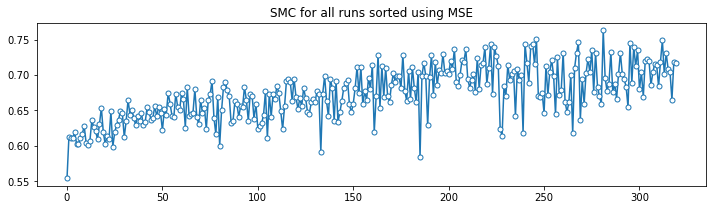

In [59]:
# Check SMC
plt.figure(figsize=(12,3))
plt.plot(tsNMF_results['SMC'][r_idx][run_idx_sorted], '.-', markersize=10, markerfacecolor='w')
plt.title('SMC for all runs sorted using MSE')
plt.show()

In [60]:
# Select run_idx_sorted[1] instead of run_idx_sorted[0]
run_idx_sel = run_idx_sorted[1]

In [61]:
# component number sequence matching index
new_comp_seq_idx = match_idx_by_H_NMF[r_idx][run_idx_sel, :]  # instead of run_idx_sorted[0]

In [62]:
new_comp_seq_idx

array([1, 3, 0, 2])

In [63]:
# sort and reshape Hs and Ws for display
H_type = 'H_multW'
W_type = 'W_divW'
Ws_reshaped = np.array(tsNMF_results[W_type][r_idx])[run_idx_sel, :, new_comp_seq_idx].\
                reshape(rank_to_check, n_frequencies*n_depth_levels, n_pings)
Hs_reshaped = np.array(tsNMF_results[H_type][r_idx])[run_idx_sel, new_comp_seq_idx, :].T

### Which random seed?

In [64]:
run_idx_sel

96

In [65]:
# run index selected
tsNMF_results['filenum_linenum_original'][r_idx][run_idx_sel]

96

In [66]:
# Double check we can recover that exact run
file_num_sel, line_num_sel = tsNMF_results['filenum_linenum'][r_idx][run_idx_sel]

In [67]:
all_fname[file_num_sel]

'../data/precalc_tsnmf/smoothness_sweep_dict/sm5e5_sp0/ssNMF_sm5e+05_sp0.0_batch19.pkl'

In [68]:
with open(all_fname[file_num_sel],'rb') as openfile:
    x = dill.load(openfile)

In [69]:
W_recover = x[line_num_sel]['W']
H_recover = x[line_num_sel]['H']

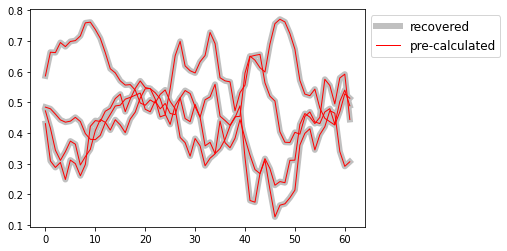

In [70]:
h1 = plt.plot(H_recover.T, color='silver', lw=6)
h2 = plt.plot(tsNMF_results['H'][r_idx][run_idx_sel].T, color='r', lw=1)
plt.legend([h1[0], h2[0]], ['recovered', 'pre-calculated'], fontsize=12, bbox_to_anchor=(1,1))
plt.show()

From the above we know that we can exactly recover this run.

### Sanity check: re-run tsNMF using the random seed

Let's see if we can re-run tsNMF can get the same output when using the same initial condition and early-stopping parameters.

In [71]:
model = tsnmf.smoothNMF(n_components=4, 
                        max_iter=2000, 
                        smoothness=500000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model.fit(low_rank_nonneg.T, init='random', random_state=960)

Stopping at iteration 797


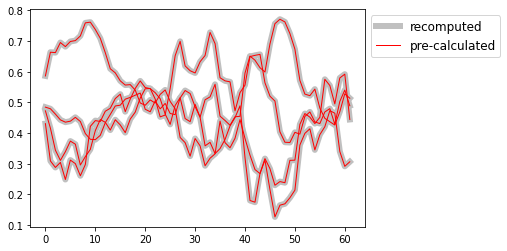

In [72]:
h1 = plt.plot(model.H.T, color='silver', lw=6)
h2 = plt.plot(tsNMF_results['H'][r_idx][run_idx_sel].T, color='r', lw=1)
plt.legend([h1[0], h2[0]], ['recomputed', 'pre-calculated'], fontsize=12, bbox_to_anchor=(1,1))
plt.show()

We have verified that this initial random seed does lead to exactly the same results.